In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import pandas as pd
import io
import numpy as np
from nltk.corpus import stopwords
from textblob import Word
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tkinter import *
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

df_train = pd.read_csv('/content/train.txt', names=['content', 'sentiment'], sep=';')
df_test = pd.read_csv('/content/test.txt', names=['content', 'sentiment'], sep=';')
# data = pd.read_csv('/content/emotion.csv')
data = df_train.append(df_test)
# data = data.drop('author', axis=1)

# # Dropping rows with other emotion labels
# data = data.drop(data[data.sentiment == 'anger'].index)
# data = data.drop(data[data.sentiment == 'boredom'].index)
# data = data.drop(data[data.sentiment == 'enthusiasm'].index)
# data = data.drop(data[data.sentiment == 'empty'].index)
# # data = data.drop(data[data.sentiment == 'fun'].index)
# data = data.drop(data[data.sentiment == 'relief'].index)
# data = data.drop(data[data.sentiment == 'surprise'].index)
# # data = data.drop(data[data.sentiment == 'love'].index)
# data = data.drop(data[data.sentiment == 'hate'].index)
# # data = data.drop(data[data.sentiment == 'neutral'].index)
# # data = data.drop(data[data.sentiment == 'worry'].index)

# Making all letters lowercase
data['content'] = data['content'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing Punctuation, Symbols
data['content'] = data['content'].str.replace('[^\w\s]',' ')

# Removing Stop Words using NLTK
stop = stopwords.words('english')
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#Lemmatisation
data['content'] = data['content'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# #removing numbers
# data['content']=''.join([i for i in data['content'] if not i.isdigit()])


#Correcting Letter Repetitions

def de_repeat(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

data['content'] = data['content'].apply(lambda x: " ".join(de_repeat(x) for x in x.split()))

# Code to find the top 10,000 rarest words appearing in the data
freq = pd.Series(' '.join(data['content']).split()).value_counts()[-10000:]

# Removing all those rarely appearing words from the data
freq = list(freq.index)
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

#Encoding output labels 'sadness' as '1' & 'happiness' as '0'
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(data.sentiment.values)


# Splitting into training and testing data in 80:20 ratio
X_train, X_val, y_train, y_val = train_test_split(data.content.values, y, stratify=y, random_state=42, test_size=0.25, shuffle=True)

# Extracting TF-IDF parameters
tfidf = TfidfVectorizer(max_features=10000, analyzer='word',ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.fit_transform(X_val)

# Extracting Count Vectors Parameters
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(data['content'])
X_train_count =  count_vect.transform(X_train)
X_val_count =  count_vect.transform(X_val)

#TF-IDF
# Model 1: Linear SVM
lsvm = SGDClassifier(alpha=0.0001, random_state=5, max_iter=5000, tol=None)
lsvm.fit(X_train_tfidf, y_train)
y_pred = lsvm.predict(X_val_tfidf)
print('svm using tfidf accuracy %s' % accuracy_score(y_pred, y_val))

# Model 2: Random Forest Classifier
rf = RandomForestClassifier(n_estimators=700)
rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_val_tfidf)
print('random forest tfidf accuracy %s' % accuracy_score(y_pred, y_val))

# Model 3: logistic regression
logreg = LogisticRegression(solver='liblinear', max_iter=5000)
logreg.fit(X_train_tfidf, y_train)
y_pred = logreg.predict(X_val_tfidf)
print('log reg tfidf accuracy %s' % accuracy_score(y_pred, y_val))


## Building models using count vectors feature
# Model 1: Linear SVM
lsvm = SGDClassifier(alpha=0.0001, random_state=5, max_iter=5000, tol=None, class_weight="balanced")
lsvm.fit(X_train_count, y_train)
y_pred = lsvm.predict(X_val_count)
print('lsvm using count vectors accuracy %s' % accuracy_score(y_pred, y_val))

# Model 2: Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train_count, y_train)
y_pred = rf.predict(X_val_count)
print('random forest with count vectors accuracy %s' % accuracy_score(y_pred, y_val))

# Model 3: Logistic Regression
logreg = LogisticRegression(solver='liblinear', max_iter=5000)
logreg.fit(X_train_count, y_train)
y_pred = logreg.predict(X_val_count)
print('log reg count vectors accuracy %s' % accuracy_score(y_pred, y_val))

# nb = MultinomialNB()
# nb.fit(X_train_count, y_train)
# y_pred = nb.predict(X_val_count)
# print('naive bayes count vectors accuracy %s' % accuracy_score(y_pred, y_val))

#Below are 8 random statements. The first 4 depict happiness. The last 4 depict sadness

# tweets = pd.DataFrame(['I am very happy today! The atmosphere looks cheerful',
# 'Things are looking great. It was such a good day',
# 'Success is right around the corner. Lets celebrate this victory',
# 'Everything is more beautiful when you experience them with a smile!',
# 'Now this is my worst, okay? But I am gonna get better.',
# 'I am tired, boss. Tired of being on the road, lonely as a sparrow in the rain. I am tired of all the pain I feel',
# 'This is quite depressing. I am filled with sorrow',
# 'His death broke my heart. It was a sad day'])

# # Doing some preprocessing on these tweets as done before
# tweets[0] = tweets[0].str.replace('[^\w\s]',' ')
# from nltk.corpus import stopwords
# stop = stopwords.words('english')
# tweets[0] = tweets[0].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# from textblob import Word
# tweets[0] = tweets[0].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# # Extracting Count Vectors feature from our tweets
# tweet_count = count_vect.transform(tweets[0])

# #Predicting the emotion of the tweet using our already trained LR
# tweet_pred = logreg.predict(tweet_count)
# print(tweet_pred)
# ## result
## [0 0 0 0 1 1 1 1]


<ipython-input-23-f98ba263c4ce>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_train.append(df_test)
<ipython-input-23-f98ba263c4ce>:45: FutureWarning: The default value of regex will change from True to False in a future version.
  data['content'] = data['content'].str.replace('[^\w\s]',' ')


svm using tfidf accuracy 0.2782222222222222
random forest tfidf accuracy 0.162
log reg tfidf accuracy 0.3015555555555556
lsvm using count vectors accuracy 0.8853333333333333
random forest with count vectors accuracy 0.8773333333333333
log reg count vectors accuracy 0.8906666666666667


<Axes: >

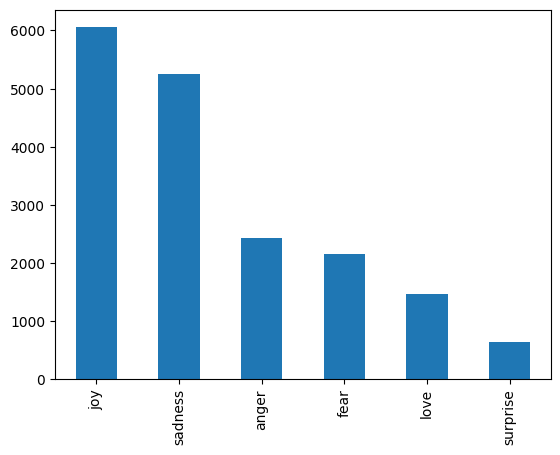

In [ ]:
data['sentiment'].value_counts().plot(kind='bar')

In [ ]:
logreg.classes_

array([0, 1, 2, 3, 4, 5])

In [ ]:
#@title GUI Implementation
Text = 'i was stunned to hear the news' #@param {type:"string"}
print(Text)
tweets = pd.DataFrame([Text])
# Doing some preprocessing on these tweets as done before
tweets[0] = tweets[0].str.replace('[^\w\s]',' ')
from nltk.corpus import stopwords
stop = stopwords.words('english')
tweets[0] = tweets[0].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
from textblob import Word
tweets[0] = tweets[0].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
# Extracting Count Vectors feature from our tweets
tweet_count = count_vect.transform(tweets[0])
# Predicting the emotion of the tweet using our already trained linear SVM
tweet_pred = logreg.predict(tweet_count)
print(tweet_pred)

i was stunned to hear the news
[5]


<ipython-input-56-21db55ffe6d9>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets[0] = tweets[0].str.replace('[^\w\s]',' ')


In [ ]:
from sklearn.utils.multiclass import unique_labels

In [ ]:
def plot1(y_val,y_pred):
  labels=unique_labels(y_val)
  column=[f'Predicted {label}' for label in labels]
  indices=[f'Actual {label}' for label in labels]
  table=pd.DataFrame(confusion_matrix(y_val,y_pred),columns=column,index=indices)
  return table

In [ ]:
plot1(y_val,y_pred)

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5
Actual 0,524,13,28,6,37,0
Actual 1,14,464,12,2,30,18
Actual 2,12,6,1420,49,20,7
Actual 3,4,1,83,275,3,0
Actual 4,34,18,34,9,1215,2
Actual 5,1,25,18,1,5,110


In [ ]:
import seaborn as sns

In [ ]:
def plot2(y_val,y_pred):
  labels=unique_labels(y_val)
  column=[f'Predicted {label}' for label in labels]
  indices=[f'Actual {label}' for label in labels]
  table=pd.DataFrame(confusion_matrix(y_val,y_pred),columns=column,index=indices)
  return sns.heatmap(table, annot=True, fmt='d')

<Axes: >

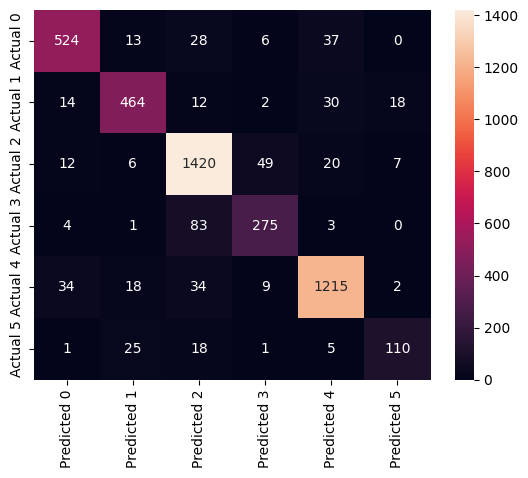

In [ ]:
plot2(y_val,y_pred)